In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [61]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 6))

In [62]:
rand_sub_bval_indice_100206

array([144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287])

In [63]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [64]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [65]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [66]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [67]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

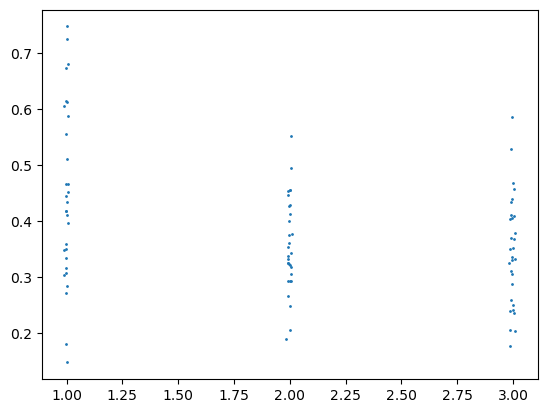

In [68]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [49]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [69]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [70]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(90, 3)


In [71]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [72]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [73]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:22<00:00, 328.93it/s]


Loss: 574.9320141132921
Average Loss: 0.07867159470625235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.89it/s]


Loss: 418.2597473124042
Average Loss: 0.05723313455287414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.80it/s]


Loss: 414.1686307336204
Average Loss: 0.056673321118448326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.86it/s]


Loss: 412.98582432279363
Average Loss: 0.05651147021384697
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.23it/s]


Loss: 412.4406059589237
Average Loss: 0.056436864526398976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.96it/s]


Loss: 411.53289240272716
Average Loss: 0.05631265632221225
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.63it/s]


Loss: 411.5809511204716
Average Loss: 0.05631923250143289
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.76it/s]


Loss: 411.17186561971903
Average Loss: 0.05626325473723577
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.44it/s]


Loss: 411.1387459386606
Average Loss: 0.056258722761174135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.97it/s]


Loss: 410.20283921342343
Average Loss: 0.056130656706817654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|███▏                                                                                                                                                          | 149/7308 [00:02<00:47, 151.68it/s]

X_batch: 
torch.Size([128, 90])
tensor([[0.4766, 0.3255, 0.1439,  ..., 0.4312, 0.3491, 0.1650],
        [0.4081, 0.2098, 0.3064,  ..., 0.5245, 0.3799, 0.2894],
        [0.3361, 0.3635, 0.1356,  ..., 0.3116, 0.3860, 0.3632],
        ...,
        [0.3828, 0.2290, 0.1243,  ..., 0.3635, 0.2129, 0.0657],
        [0.2321, 0.0886, 0.0984,  ..., 0.2256, 0.1137, 0.0622],
        [0.5180, 0.2557, 0.2751,  ..., 0.6030, 0.3889, 0.2641]])
X_pred: 
torch.Size([128, 90])
tensor([[0.4634, 0.2686, 0.1592,  ..., 0.4514, 0.2629, 0.1700],
        [0.4653, 0.2752, 0.1631,  ..., 0.4551, 0.2715, 0.1754],
        [0.4469, 0.3118, 0.2105,  ..., 0.4310, 0.3037, 0.2327],
        ...,
        [0.3849, 0.1912, 0.1041,  ..., 0.3763, 0.1890, 0.1120],
        [0.2180, 0.1112, 0.0724,  ..., 0.2121, 0.1100, 0.0804],
        [0.5438, 0.3608, 0.2291,  ..., 0.5286, 0.3516, 0.2439]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.12it/s]


Loss: 410.1340581632685
Average Loss: 0.05612124495939635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.25it/s]


Loss: 409.4767269352451
Average Loss: 0.05603129815753217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.67it/s]


Loss: 409.5222608009353
Average Loss: 0.056037528845229244
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.71it/s]


Loss: 408.8444498050958
Average Loss: 0.05594477966681661
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.43it/s]


Loss: 408.570169450948
Average Loss: 0.05590724814599726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.93it/s]


Loss: 408.7365683456883
Average Loss: 0.05593001756235472
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.43it/s]


Loss: 408.6395243983716
Average Loss: 0.05591673842342249
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.44it/s]


Loss: 408.7759069262538
Average Loss: 0.05593540050988695
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.81it/s]


Loss: 408.0134530798532
Average Loss: 0.0558310691132804
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.48it/s]


Loss: 408.4393955527339
Average Loss: 0.05588935352390995
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.69it/s]


Loss: 407.92192258359864
Average Loss: 0.055818544414832874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.23it/s]


Loss: 408.14088105317205
Average Loss: 0.05584850589123865
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.83it/s]


Loss: 407.71780527289957
Average Loss: 0.05579061374834422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.05it/s]


Loss: 407.6966185425408
Average Loss: 0.05578771463362627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.18it/s]


Loss: 408.17883148859255
Average Loss: 0.05585369889006466
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.31it/s]


Loss: 407.9629367575981
Average Loss: 0.05582415664444418
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.07it/s]


Loss: 407.59657505713403
Average Loss: 0.055774025048868914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.98it/s]


Loss: 407.608253917424
Average Loss: 0.05577562314140996
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.59it/s]


Loss: 407.5939356398303
Average Loss: 0.05577366388065549
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.59it/s]


Loss: 407.18590484792367
Average Loss: 0.055717830438960544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.49it/s]


Loss: 407.2779343824368
Average Loss: 0.05573042342397876
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.14it/s]


Loss: 406.97393387556076
Average Loss: 0.0556888251061249
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.64it/s]


Loss: 406.7822401775047
Average Loss: 0.05566259444136627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.51it/s]


Loss: 406.80894020665437
Average Loss: 0.05566624797573267
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.04it/s]


Loss: 406.7881374533754
Average Loss: 0.0556634014030344
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.71it/s]


Loss: 406.58813893352635
Average Loss: 0.05563603433682627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.07it/s]


Loss: 406.24469887604937
Average Loss: 0.0555890392550697
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.52it/s]


Loss: 406.2433978638146
Average Loss: 0.05558886122931234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.77it/s]


Loss: 406.23605932691135
Average Loss: 0.055587857050754155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.94it/s]


Loss: 405.97432985156775
Average Loss: 0.055552042946301006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.62it/s]


Loss: 406.0740845266264
Average Loss: 0.055565693011306296
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.35it/s]


Loss: 405.8144849408418
Average Loss: 0.055530170353152955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.06it/s]


Loss: 406.03648435953073
Average Loss: 0.05556054794191718
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.92it/s]


Loss: 405.6290923266206
Average Loss: 0.055504801905667846
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.14it/s]


Loss: 405.7400717991404
Average Loss: 0.055519987930916864
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.80it/s]


Loss: 406.0496887213085
Average Loss: 0.05556235477850417
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.35it/s]


Loss: 405.57634418131784
Average Loss: 0.05549758404232592
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.95it/s]


Loss: 405.5183398909867
Average Loss: 0.05548964694731619
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.64it/s]


Loss: 405.4001748585142
Average Loss: 0.05547347767631557
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.04it/s]


Loss: 405.71314637130126
Average Loss: 0.055516303553817904
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.81it/s]


Loss: 405.53337666462176
Average Loss: 0.05549170452444195
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.30it/s]


Loss: 405.4501883620396
Average Loss: 0.055480321341275264
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.21it/s]


Loss: 405.4043112208601
Average Loss: 0.05547404368101534
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.83it/s]


Loss: 405.2758039389737
Average Loss: 0.055456459214418954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.74it/s]


Loss: 405.3459694532212
Average Loss: 0.055466060406844715
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.71it/s]


Loss: 405.12283580447547
Average Loss: 0.055435527614186575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.28it/s]


Loss: 405.2653721556999
Average Loss: 0.05545503176733715
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.25it/s]


Loss: 405.3909771628678
Average Loss: 0.05547221909727255
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.17it/s]


Loss: 405.09440582990646
Average Loss: 0.05543163736041413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.21it/s]


Loss: 405.045451980317
Average Loss: 0.055424938694624656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.68it/s]


Loss: 404.85487361159176
Average Loss: 0.05539886064745372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.41it/s]


Loss: 404.9552493633237
Average Loss: 0.055412595698320154
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.05it/s]


Loss: 405.0318452324718
Average Loss: 0.055423076796999426
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.58it/s]


Loss: 405.1830719332211
Average Loss: 0.05544377010580474
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.33it/s]


Loss: 404.9221578629222
Average Loss: 0.05540806757839658
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.46it/s]


Loss: 404.9195767068304
Average Loss: 0.05540771438243437
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.64it/s]


Loss: 404.9530574269593
Average Loss: 0.055412295761762355
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.42it/s]


Loss: 404.81356211612
Average Loss: 0.055393207733459224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.29it/s]


Loss: 404.723900974961
Average Loss: 0.05538093883072811
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.45it/s]


Loss: 404.801799361594
Average Loss: 0.05539159816113766
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.64it/s]


Loss: 404.34346216986887
Average Loss: 0.05532888097562519
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.25it/s]


Loss: 402.59381368244067
Average Loss: 0.05508946547378772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.65it/s]


Loss: 401.96837177686393
Average Loss: 0.05500388229021127
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.33it/s]


Loss: 401.55525553715415
Average Loss: 0.0549473529744327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.79it/s]


Loss: 401.5768905656878
Average Loss: 0.0549503134326338
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.68it/s]


Loss: 401.16834099031985
Average Loss: 0.05489440900250682
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.77it/s]


Loss: 400.9430270749144
Average Loss: 0.0548635778701306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.00it/s]


Loss: 400.9823591380846
Average Loss: 0.054868959925846277
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.08it/s]


Loss: 400.6792742430698
Average Loss: 0.05482748689697178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.08it/s]


Loss: 400.9405589948874
Average Loss: 0.05486324014708366
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.32it/s]


Loss: 400.3719108265359
Average Loss: 0.054785428410856034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.15it/s]


Loss: 400.38227544911206
Average Loss: 0.05478684666791353
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.21it/s]


Loss: 400.1727127826307
Average Loss: 0.0547581708788493
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.26it/s]


Loss: 400.2761756060645
Average Loss: 0.054772328353320264
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.64it/s]


Loss: 400.07090506283566
Average Loss: 0.05474423988270877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.32it/s]


Loss: 400.089345758548
Average Loss: 0.054746763240085934
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.66it/s]


Loss: 399.97673314926215
Average Loss: 0.054731353742373035
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.91it/s]


Loss: 399.65649414411746
Average Loss: 0.054687533407788376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.34it/s]


Loss: 399.6700761015527
Average Loss: 0.05468939191318455
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.05it/s]


Loss: 399.4308159460779
Average Loss: 0.054656652428308417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.74it/s]


Loss: 399.4855259351898
Average Loss: 0.054664138743184154
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.18it/s]


Loss: 399.18286604224704
Average Loss: 0.054622723870039275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.85it/s]


Loss: 399.2864858438261
Average Loss: 0.05463690282482568
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.52it/s]


Loss: 399.02349812421016
Average Loss: 0.054600916546826785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.99it/s]


Loss: 398.8074673146475
Average Loss: 0.05457135568071258
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.33it/s]


Loss: 398.63366327178665
Average Loss: 0.0545475729709615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.26it/s]


Loss: 398.65447413083166
Average Loss: 0.05455042065282316
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.42it/s]


Loss: 398.546886541415
Average Loss: 0.05453569876045635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.40it/s]


Loss: 398.35021042171866
Average Loss: 0.054508786319337525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.88it/s]


Loss: 398.4738942438271
Average Loss: 0.05452571076133376
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.35it/s]


Loss: 397.9935741974041
Average Loss: 0.054459985522359616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.46it/s]


Loss: 398.00149546400644
Average Loss: 0.05446106943951922
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.56it/s]


Loss: 397.85489873751067
Average Loss: 0.054441009679462325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.57it/s]


Loss: 397.9691916438751
Average Loss: 0.054456649102883836
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.50it/s]


Loss: 397.7652474802453
Average Loss: 0.05442874212920708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.85it/s]


Loss: 397.5795790415723
Average Loss: 0.054403335938912466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.03it/s]


Loss: 397.55793674034066
Average Loss: 0.05440037448554196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.04it/s]


Loss: 397.59396408172324
Average Loss: 0.05440530433521117
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.02it/s]


Loss: 397.41505864146166
Average Loss: 0.05438082356889185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.80it/s]


Loss: 397.42579720099457
Average Loss: 0.054382292994115296
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.12it/s]


Loss: 397.2546589169651
Average Loss: 0.054358875057055986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.64it/s]


Loss: 397.11689012823626
Average Loss: 0.05434002327972581
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.89it/s]


Loss: 397.20098940236494
Average Loss: 0.05435153111690817
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.22it/s]


Loss: 397.2490100755822
Average Loss: 0.054358102090254816
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.79it/s]


Loss: 396.9312987048179
Average Loss: 0.05431462762791706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.26it/s]


Loss: 397.12256471440196
Average Loss: 0.05434079976934893
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.23it/s]


Loss: 396.7692294262815
Average Loss: 0.05429245066041072
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.17it/s]


Loss: 396.92221633531153
Average Loss: 0.05431338482968138
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.98it/s]


Loss: 396.564889379777
Average Loss: 0.05426448951556883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.52it/s]


Loss: 396.73411396401934
Average Loss: 0.05428764558894627
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.27it/s]


Loss: 396.7223039935343
Average Loss: 0.0542860295557655
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.87it/s]


Loss: 396.5953629852738
Average Loss: 0.05426865941232537
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.92it/s]


Loss: 396.44918747991323
Average Loss: 0.05424865729062852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.72it/s]


Loss: 396.65504631679505
Average Loss: 0.05427682626119253
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.23it/s]


Loss: 396.2892467151396
Average Loss: 0.054226771581163055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.38it/s]


Loss: 396.41552443802357
Average Loss: 0.054244050963057414
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.90it/s]


Loss: 396.5153306804132
Average Loss: 0.054257708084347725
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.53it/s]


Loss: 396.1374028485734
Average Loss: 0.05420599382164387
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.62it/s]


Loss: 396.1868606118951
Average Loss: 0.05421276144114602
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.34it/s]


Loss: 396.06067289877683
Average Loss: 0.054195494375858896
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.51it/s]


Loss: 396.1169798222836
Average Loss: 0.054203199209398416
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.11it/s]


Loss: 396.28923955070786
Average Loss: 0.05422677060080841
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.87it/s]


Loss: 396.08937100856565
Average Loss: 0.054199421320274443
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.30it/s]


Loss: 396.04870075243525
Average Loss: 0.05419385615112688
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.37it/s]


Loss: 395.97009110543877
Average Loss: 0.05418309949444975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.68it/s]


Loss: 395.9316800888628
Average Loss: 0.05417784347138243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.48it/s]


Loss: 396.03015405870974
Average Loss: 0.05419131828936915
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.02it/s]


Loss: 395.902065029135
Average Loss: 0.05417379105488984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.91it/s]


Loss: 395.69498164439574
Average Loss: 0.0541454545216743
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.06it/s]


Loss: 395.73063212586567
Average Loss: 0.05415033280321096
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.49it/s]


Loss: 395.6078685838729
Average Loss: 0.05413353428898097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.71it/s]


Loss: 395.7491292844061
Average Loss: 0.054152863886755075
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.84it/s]


Loss: 395.6429818072356
Average Loss: 0.0541383390540826
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.70it/s]


Loss: 395.6222624601796
Average Loss: 0.05413550389438692
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.72it/s]


Loss: 395.6215078756213
Average Loss: 0.054135400639794926
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.12it/s]


Loss: 395.5812546245288
Average Loss: 0.054129892532092064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.88it/s]


Loss: 395.61726151872426
Average Loss: 0.05413481958384295
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.42it/s]


Loss: 395.52519017341547
Average Loss: 0.05412222087758832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.20it/s]


Loss: 395.5692999307066
Average Loss: 0.05412825669549899
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.84it/s]


Loss: 395.4333931731526
Average Loss: 0.054109659711706705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.32it/s]


Loss: 395.33655701810494
Average Loss: 0.054096409006308833
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.55it/s]


Loss: 395.36924380017444
Average Loss: 0.05410088174605562
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.54it/s]


Loss: 395.48660195525736
Average Loss: 0.0541169406069044
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.98it/s]


Loss: 395.46795380092226
Average Loss: 0.05411438886164782
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.94it/s]


Loss: 395.2768443771638
Average Loss: 0.05408823814684781
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.72it/s]


Loss: 395.3005724400282
Average Loss: 0.054091485008214035
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.42it/s]


Loss: 395.2966739758849
Average Loss: 0.0540909515566345
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.42it/s]


Loss: 395.2269027219154
Average Loss: 0.05408140431334365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.79it/s]


Loss: 395.2007229353767
Average Loss: 0.05407782196707399
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.89it/s]


Loss: 395.24636699655093
Average Loss: 0.05408406773351819
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.40it/s]


Loss: 395.1955751988571
Average Loss: 0.05407711756963015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.57it/s]


Loss: 395.28693559137173
Average Loss: 0.05408961899170385
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.00it/s]


Loss: 394.9612650354393
Average Loss: 0.05404505542356859
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.25it/s]


Loss: 395.0825333611574
Average Loss: 0.05406164933787047
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.77it/s]


Loss: 395.17709134565666
Average Loss: 0.0540745883067401
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.96it/s]


Loss: 394.96947185648605
Average Loss: 0.0540461784149543
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.14it/s]


Loss: 395.12969821784645
Average Loss: 0.054068103204412486
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.72it/s]


Loss: 394.92061336524785
Average Loss: 0.05403949279765296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.17it/s]


Loss: 394.92550939740613
Average Loss: 0.0540401627527923
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.93it/s]


Loss: 394.91023405990563
Average Loss: 0.054038072531459445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.83it/s]


Loss: 394.8768396752421
Average Loss: 0.05403350296596088
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.92it/s]


Loss: 394.88443626789376
Average Loss: 0.05403454245592416
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.32it/s]


Loss: 394.84969543130137
Average Loss: 0.05402978864686663
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.03it/s]


Loss: 394.86774782440625
Average Loss: 0.054032258870334735
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.02it/s]


Loss: 394.8252487266436
Average Loss: 0.054026443449184954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.14it/s]


Loss: 394.71535334852524
Average Loss: 0.05401140576745009
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.70it/s]


Loss: 394.9422743769828
Average Loss: 0.05404245681130033
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.32it/s]


Loss: 394.8258058500942
Average Loss: 0.054026519683920936
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.02it/s]


Loss: 394.7888150520157
Average Loss: 0.05402145799836011
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.40it/s]


Loss: 394.56713427440263
Average Loss: 0.053991124011275676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.65it/s]


Loss: 394.7155604492873
Average Loss: 0.05401143410636115
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.42it/s]


Loss: 394.84540557069704
Average Loss: 0.054029201638026415
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.72it/s]


Loss: 394.71945501095615
Average Loss: 0.05401196702394036
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.05it/s]


Loss: 394.5770091130398
Average Loss: 0.05399247524808974
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.54it/s]


Loss: 394.492988249287
Average Loss: 0.05398097814029652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.71it/s]


Loss: 394.53585109789856
Average Loss: 0.053986843335782506
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.44it/s]


Loss: 394.73226455785334
Average Loss: 0.05401371983550265
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.95it/s]


Loss: 394.4075676014181
Average Loss: 0.05396928949116285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.24it/s]


Loss: 394.3842445453629
Average Loss: 0.053966098049447575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.99it/s]


Loss: 394.4699426773004
Average Loss: 0.05397782466848665
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.30it/s]


Loss: 394.4371251950506
Average Loss: 0.05397333404420507
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.51it/s]


Loss: 394.43319177581
Average Loss: 0.053972795809497806
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.34it/s]


Loss: 394.33962489455007
Average Loss: 0.05395999245957171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.38it/s]


Loss: 394.4480574121699
Average Loss: 0.05397482996882456
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.14it/s]


Loss: 394.28289995295927
Average Loss: 0.05395223042596597
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.52it/s]


Loss: 394.27718200394884
Average Loss: 0.053951448002729725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.07it/s]


Loss: 394.38814708054997
Average Loss: 0.053966632058093864
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.11it/s]


Loss: 394.39944409928285
Average Loss: 0.05396817790083235
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.98it/s]


Loss: 394.27990429871716
Average Loss: 0.053951820511592384
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.07it/s]


Loss: 394.2351374756545
Average Loss: 0.053945694783203955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.93it/s]


Loss: 394.09277074062265
Average Loss: 0.05392621383971301
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.95it/s]


Loss: 394.2257839832455
Average Loss: 0.05394441488550157
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.32it/s]


Loss: 394.26245565293357
Average Loss: 0.05394943290270027
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.26it/s]


Loss: 394.1394793721847
Average Loss: 0.05393260527807673
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.26it/s]


Loss: 394.02506513893604
Average Loss: 0.053916949252727976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.30it/s]


Loss: 394.2240576718468
Average Loss: 0.05394417866336163
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.06it/s]


Loss: 394.0775211919099
Average Loss: 0.053924127147223576
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.34it/s]


Loss: 394.17141904938035
Average Loss: 0.053936975786724184
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.44it/s]


Loss: 394.15488913003355
Average Loss: 0.05393471389299857
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.85it/s]


Loss: 393.9039544498082
Average Loss: 0.05390037690884075
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.84it/s]


Loss: 394.10891434992664
Average Loss: 0.053928422872184814
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.48it/s]


Loss: 393.95005267322995
Average Loss: 0.053906684821186365
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.74it/s]


Loss: 394.02731238212436
Average Loss: 0.05391725675726934
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.68it/s]


Loss: 393.9109619006049
Average Loss: 0.05390133578278666
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.61it/s]


Loss: 393.93385919276625
Average Loss: 0.0539044689645274
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.70it/s]


Loss: 393.89815792720765
Average Loss: 0.05389958373388173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.34it/s]


Loss: 393.85195390996523
Average Loss: 0.053893261345096505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.30it/s]


Loss: 393.89435544540174
Average Loss: 0.053899063416174293
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.20it/s]


Loss: 394.0822051046416
Average Loss: 0.05392476807671615
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.54it/s]


Loss: 393.76258672983386
Average Loss: 0.05388103266691761
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.29it/s]


Loss: 393.75501520978287
Average Loss: 0.053879996607797326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.22it/s]


Loss: 393.79618374374695
Average Loss: 0.05388562995946181
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.46it/s]


Loss: 393.7898740740493
Average Loss: 0.053884766567330225
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.03it/s]


Loss: 393.7302531651221
Average Loss: 0.0538766082601426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.65it/s]


Loss: 393.88708603032865
Average Loss: 0.053898068695994616
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.65it/s]


Loss: 393.70131208957173
Average Loss: 0.05387264806918059
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.71it/s]


Loss: 393.7498863574583
Average Loss: 0.05387929479439769
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.45it/s]


Loss: 393.74277363484725
Average Loss: 0.053878321515441606
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.36it/s]


Loss: 393.6170091992244
Average Loss: 0.05386111236989934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.13it/s]


Loss: 393.5724732866511
Average Loss: 0.053855018238458
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.62it/s]


Loss: 393.6032862246502
Average Loss: 0.05385923456823347
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.89it/s]


Loss: 393.62351467530243
Average Loss: 0.0538620025554601
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.24it/s]


Loss: 393.64610083703883
Average Loss: 0.05386509316325107
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.74it/s]


Loss: 393.5792877874337
Average Loss: 0.053855950709829466
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.50it/s]


Loss: 393.5463388597127
Average Loss: 0.0538514420990302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.96it/s]


Loss: 393.5556733114645
Average Loss: 0.05385271939127866
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.61it/s]


Loss: 393.50328536494635
Average Loss: 0.05384555081622145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.90it/s]


Loss: 393.55471088085324
Average Loss: 0.05385258769579272
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.97it/s]


Loss: 393.5853346711956
Average Loss: 0.05385677814329442
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.93it/s]


Loss: 393.5992456341628
Average Loss: 0.05385868166860465
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.41it/s]


Loss: 393.45527455280535
Average Loss: 0.05383898119222843
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.98it/s]


Loss: 393.46105898031965
Average Loss: 0.05383977271214007
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.53it/s]


Loss: 393.3421604067553
Average Loss: 0.053823503066058466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.74it/s]


Loss: 393.3983873894904
Average Loss: 0.05383119696079507
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.11it/s]


Loss: 393.42432091594674
Average Loss: 0.05383474560973546
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.48it/s]


Loss: 393.42372442339547
Average Loss: 0.05383466398787568
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.12it/s]


Loss: 393.5094954757951
Average Loss: 0.05384640058508417
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.16it/s]


Loss: 393.3957549647894
Average Loss: 0.053830836749423835
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.76it/s]


Loss: 393.4469140090514
Average Loss: 0.05383783716598952
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.72it/s]


Loss: 393.32940278411843
Average Loss: 0.053821757359622115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.33it/s]


Loss: 393.2942487334367
Average Loss: 0.053816947007859425
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.28it/s]


Loss: 393.44559248466976
Average Loss: 0.05383765633342498
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.04it/s]


Loss: 393.32082193531096
Average Loss: 0.053820583187645175
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.41it/s]


Loss: 393.3635893696919
Average Loss: 0.053826435326996706
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.18it/s]


Loss: 393.4180209990591
Average Loss: 0.05383388355214273
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.87it/s]


Loss: 393.20323181990534
Average Loss: 0.05380449258619394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.37it/s]


Loss: 393.23427817132324
Average Loss: 0.05380874085540822
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.27it/s]


Loss: 393.2200722419657
Average Loss: 0.0538067969679756
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.72it/s]


Loss: 393.287293094676
Average Loss: 0.053815995223683084
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.18it/s]


Loss: 393.25767047540285
Average Loss: 0.053811941772769954
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.31it/s]


Loss: 393.19585486268625
Average Loss: 0.05380348315034021
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.03it/s]


Loss: 393.30912833311595
Average Loss: 0.05381898307787575
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.46it/s]


Loss: 393.1203097323887
Average Loss: 0.05379314583092347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.99it/s]


Loss: 393.19611926120706
Average Loss: 0.053803519329667086
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.32it/s]


Loss: 393.1175039848313
Average Loss: 0.053792761902686274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.13it/s]


Loss: 393.2721168000717
Average Loss: 0.05381391855501802
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.42it/s]


Loss: 393.12754519539885
Average Loss: 0.05379413590522699
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.71it/s]


Loss: 393.0586934047751
Average Loss: 0.053784714477938575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.28it/s]


Loss: 393.13438119529746
Average Loss: 0.05379507131845888
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.48it/s]


Loss: 393.1649382908363
Average Loss: 0.0537992526396875
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.00it/s]


Loss: 393.14875078899786
Average Loss: 0.05379703760112176
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.45it/s]


Loss: 393.1832232908346
Average Loss: 0.053801754692232424
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.74it/s]


Loss: 392.9975038119592
Average Loss: 0.05377634151778314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.08it/s]


Loss: 393.1227827919647
Average Loss: 0.053793484235353684
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.63it/s]


Loss: 393.177752596559
Average Loss: 0.05380100610243008
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.79it/s]


Loss: 393.0464572797064
Average Loss: 0.053783040131322714
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.36it/s]


Loss: 393.0958874432836
Average Loss: 0.053789803974176736
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.44it/s]


Loss: 393.0131037507672
Average Loss: 0.05377847615637208
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.40it/s]


Loss: 393.08137562451884
Average Loss: 0.053787818229956055
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.80it/s]


Loss: 393.1287490183022
Average Loss: 0.053794300631951585
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.02it/s]


Loss: 393.0178061912302
Average Loss: 0.05377911962113166
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.93it/s]


Loss: 393.06807324429974
Average Loss: 0.053785997980883925
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.44it/s]


Loss: 392.9006761573255
Average Loss: 0.053763091975550834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.51it/s]


Loss: 392.93708970118314
Average Loss: 0.05376807467175467
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.47it/s]


Loss: 393.07577970600687
Average Loss: 0.053787052504927046
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.58it/s]


Loss: 392.8693274531979
Average Loss: 0.05375880233349725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.27it/s]


Loss: 393.0053976373747
Average Loss: 0.05377742167999106
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.40it/s]


Loss: 392.84952735807747
Average Loss: 0.053756092960875405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.88it/s]


Loss: 392.84123254497536
Average Loss: 0.05375495792897857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.45it/s]


Loss: 392.87523446255364
Average Loss: 0.05375961062705988
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.98it/s]


Loss: 392.91096272016875
Average Loss: 0.053764499551199885
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.84it/s]


Loss: 392.84136248752475
Average Loss: 0.05375497570984192
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.33it/s]


Loss: 392.99849001923576
Average Loss: 0.05377647646678103
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.97it/s]


Loss: 392.8647128739394
Average Loss: 0.05375817089134365
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.28it/s]


Loss: 392.88391421502456
Average Loss: 0.053760798332652515
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.28it/s]


Loss: 392.7746692679357
Average Loss: 0.053745849653521575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.04it/s]


Loss: 392.77839395124465
Average Loss: 0.053746359325567136
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.12it/s]


Loss: 392.7621622872539
Average Loss: 0.053744138244013945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.98it/s]


Loss: 392.74549757805653
Average Loss: 0.053741857906138
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.02it/s]


Loss: 392.8281431924552
Average Loss: 0.05375316682983787
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.09it/s]


Loss: 392.80781303183176
Average Loss: 0.05375038492499066
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.91it/s]


Loss: 392.72090830118395
Average Loss: 0.05373849319939573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.68it/s]


Loss: 392.79010011511855
Average Loss: 0.05374796115423078
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.95it/s]


Loss: 392.7261826181784
Average Loss: 0.053739214917648936
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.05it/s]


Loss: 392.7521466424223
Average Loss: 0.05374276773979506
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.17it/s]


Loss: 392.7562144980766
Average Loss: 0.05374332437028963
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.38it/s]


Loss: 392.92993811750785
Average Loss: 0.053767096075192644
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.92it/s]


Loss: 392.67429550294764
Average Loss: 0.05373211487451391
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.88it/s]


Loss: 392.82684788876213
Average Loss: 0.053752989585216494
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.14it/s]


Loss: 392.8746430326719
Average Loss: 0.05375952969795729
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.69it/s]


Loss: 392.6858933765907
Average Loss: 0.0537337018851383
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.91it/s]


Loss: 392.8052865860518
Average Loss: 0.05375003921538749
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.57it/s]


Loss: 392.77919883769937
Average Loss: 0.05374646946328672
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.55it/s]


Loss: 392.7332137746271
Average Loss: 0.05374017703538958
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.88it/s]


Loss: 392.90691108442843
Average Loss: 0.05376394514017904
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.03it/s]


Loss: 392.661015645368
Average Loss: 0.05373029770735742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.64it/s]


Loss: 392.68161640898325
Average Loss: 0.053733116640528635
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.45it/s]


Loss: 392.59635932859965
Average Loss: 0.0537214503733716
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.55it/s]


Loss: 392.5989500656724
Average Loss: 0.053721804880360206
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.13it/s]


Loss: 392.6944762368221
Average Loss: 0.053734876332351134
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.02it/s]


Loss: 392.746747338213
Average Loss: 0.05374202891874836
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.36it/s]


Loss: 392.57136060181074
Average Loss: 0.053718029638999826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.78it/s]


Loss: 392.5801237812266
Average Loss: 0.05371922876043057
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.87it/s]


Loss: 392.5839648146648
Average Loss: 0.053719754353402406
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.83it/s]


Loss: 392.54060223698616
Average Loss: 0.05371382077681803
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.36it/s]


Loss: 392.55561062064953
Average Loss: 0.053715874469163864
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.88it/s]


Loss: 392.541457134299
Average Loss: 0.053713937757840585
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.08it/s]


Loss: 392.62022458808497
Average Loss: 0.053724716008221804
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.98it/s]


Loss: 392.68861962482333
Average Loss: 0.05373407493497856
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.65it/s]


Loss: 392.6124332603067
Average Loss: 0.053723649871415806
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.65it/s]


Loss: 392.59586214646697
Average Loss: 0.0537213823407864
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.44it/s]


Loss: 392.73241991060786
Average Loss: 0.05374006840593977
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.30it/s]


Loss: 392.58534641750157
Average Loss: 0.05371994340688308
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.11it/s]


Loss: 392.5845524480101
Average Loss: 0.05371983476300083
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.07it/s]


Loss: 392.49529480561614
Average Loss: 0.05370762107356543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.33it/s]


Loss: 392.6468565494288
Average Loss: 0.05372836022843853
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.23it/s]


Loss: 392.50067060650326
Average Loss: 0.053708356678503454
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.19it/s]


Loss: 392.7363174064085
Average Loss: 0.053740601725014846
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.94it/s]


Loss: 392.6493743574247
Average Loss: 0.05372870475607891
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.99it/s]


Loss: 392.75610735057853
Average Loss: 0.05374330970861775
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.21it/s]


Loss: 392.44758673594333
Average Loss: 0.053701092875744844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.92it/s]


Loss: 392.550114532467
Average Loss: 0.05371512240455213
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.96it/s]


Loss: 392.48763000336476
Average Loss: 0.05370657225004991
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.10it/s]


Loss: 392.56522953277454
Average Loss: 0.05371719068592974
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.95it/s]


Loss: 392.4186033059377
Average Loss: 0.05369712688915404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.83it/s]


Loss: 392.41912272549234
Average Loss: 0.053697197964626756
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.28it/s]


Loss: 392.4161641683895
Average Loss: 0.05369679312649008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.25it/s]


Loss: 392.4547778102569
Average Loss: 0.05370207687606143
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.61it/s]


Loss: 392.52280327142216
Average Loss: 0.05371138523144803
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.36it/s]


Loss: 392.4564511454664
Average Loss: 0.05370230584913334
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.06it/s]


Loss: 392.55075044720434
Average Loss: 0.053715209420799714
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.83it/s]


Loss: 392.5108033234719
Average Loss: 0.05370974320244553
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.05it/s]


Loss: 392.5737777422182
Average Loss: 0.05371836039165548
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.58it/s]


Loss: 392.5066704109777
Average Loss: 0.05370917766981085
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.43it/s]


Loss: 392.4289972127881
Average Loss: 0.05369854915336454
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.01it/s]


Loss: 392.47635054960847
Average Loss: 0.0537050288108386
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.84it/s]

Loss: 392.4793991611805
Average Loss: 0.05370544597169957
Done, best loss: 392.4161641683895
Done


<All keys matched successfully>

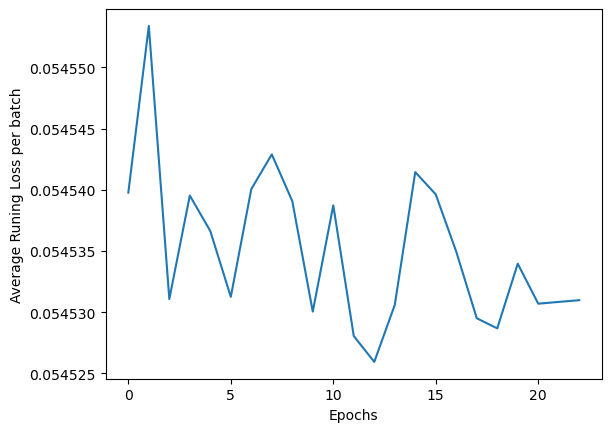

In [59]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [60]:
torch.save(final_model, 'model_100206_11g_02.pt')